# Content of the notebook

This notebook contains all steps to train and evaluate the final machine learning model that is presented in the paper "Prediction of Michaelis constants from structural features using deep learning". The notebook consists of the following steps:

1. Creating training and test data for Graph Neural Network
2. Training a Graph Neural Network
3. Training a gradient boosting model with enzyme and substrate information as inputs
4. Training a gradient boosting model with only enzyme information (UniRep vectors) as input
5. Plotting figure 4 of our paper

All datasets are stored in one directory. The location of this directory can be changed (to the corresponding path on your PC) in the python file "directory_infomation.py".

Loading all the necessary packages and functions to execute the code:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from os.path import join

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
plt.style.use('CCB_plot_style_0v4.mplstyle')
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']        # define a high contrast color scheme

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb
from tensorflow.keras import backend as K


from directory_infomation import *
from functions_and_dicts_data_preprocessing_GNN import *
from build_GNN import *

## 1. Creating training and test data for Graph Neural Network

Before we load and create the data to train and validate our machine learning models, we must calculate the feature vectors (for the atoms and bonds) for all Molfiles (if they do not already exist). If the MDL Molfiles have not yet been downloaded (e.g., by executing the notebook "Downloading and preprocessing BRENDA data"), download all files with the following cell (otherwise skip it):

In [2]:
#download_mol_files()
#calculate_atom_and_bond_feature_vectors()

In [3]:
brenda_train = pd.read_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_test = pd.read_pickle(join(datasets_dir, "splits", "test_data.pkl"))

The input vectors and matrices for the Graph Neural Network have to be calculated and saved once:

In [4]:
'''for ind in brenda_train.index:
    calculate_and_save_input_matrixes(sample_ID = "train_" + str(ind),
                                      save_folder = join(datasets_dir, "GNN_input_data"))
    
for ind in brenda_test.index:
    calculate_and_save_input_matrixes(sample_ID = "test_" + str(ind),
                                      save_folder = join(datasets_dir, "GNN_input_data"))''';

## 2. Training a Graph Neural Network

Loading data:

In [6]:
brenda_train = pd.read_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_test = pd.read_pickle(join(datasets_dir, "splits", "test_data.pkl"))

train_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
train_indices = [index[:index.rfind("_")] for index in train_indices]
train_indices = list(set([index for index in train_indices if "train" in index]))


test_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
test_indices = [index[:index.rfind("_")] for index in test_indices]
test_indices = list(set([index for index in test_indices if "test" in index]))

with open(join(datasets_dir, "splits", "CV_indices_test"), 'rb') as fp:
    CV_indices_test = pickle.load(fp)
    
with open(join(datasets_dir, "splits", "CV_indices_train"), 'rb') as fp:
    CV_indices_train = pickle.load(fp)

### (a) Performing a hyperparameter optimization (gird search) with a 5-fold Cross Validation on the training set:

In [7]:
'''count +=1

for batch_size in [32,64,96]:
    for D in [50,100]:
        for learning_rate in [0.05, 0.1, 0.2]:
            for epochs in [30, 40, 50, 80]:
                for l2_reg_fc in [0.01, 0.1, 1]:
                    for l2_reg_conv in [0.01, 0.1]:
                        for rho in [0.9, 0.95, 0.99]:
                            count +=1
                            MSE = []

                            for i in range(5):
                                train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
                                train_index = [ind for ind in train_indices if int(ind.split("_")[1]) in train_index]
                                test_index = [ind for ind in train_indices if int(ind.split("_")[1]) in test_index]

                                train_params = {'batch_size': batch_size,
                                          'folder' :join(INPUT_DATA_DIR, "GNN_input_data"),
                                          'list_IDs' : np.array(train_index),
                                          'shuffle': True}

                                test_params = {'batch_size': batch_size,
                                          'folder' : join(INPUT_DATA_DIR, "GNN_input_data"),
                                          'list_IDs' : np.array(test_index),
                                          'shuffle': False}

                                training_generator = DataGenerator(**train_params)
                                test_generator = DataGenerator(**test_params)


                                model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                                              D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)
                                model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 1)

                                #get test_y:
                                test_indices_y = [int(ind.split("_")[1]) for ind in train_indices if ind in test_index]
                                test_y = np.array([brenda_train["log10_KM"][ind] for ind in test_indices_y])

                                pred_test = model.predict(test_generator)
                                print(np.mean(abs(pred_test - np.reshape(test_y[:len(pred_test)], (-1,1)))**2))
                                MSE.append(np.mean(abs(pred_test - np.reshape(test_y[:len(pred_test)], (-1,1)))**2))

                            df = pd.DataFrame(columns = ["batch_size", "D", "learning_rate", "epochs", "l2_reg_fc", "l2_reg_conv",
                                                         "rho", "cv_mse"])
                            df = df.append({"batch_size" : batch_size, "D" : D , "learning_rate" : learning_rate, "epochs" : epochs,
                                            "l2_reg_fc" : l2_reg_fc, "l2_reg_conv" : l2_reg_conv, "rho" : rho, "cv_mse" : np.mean(MSE)},
                                           ignore_index = True)

                            df.to_csv(join(datasets_dir, "training_results", "training_results_" + str(count) + ".csv"))''';

### (c) Loading the results of the hyperparameter optimization and choosing the best set of hyperparameters:

In [8]:
hyperparameter_results = os.listdir(join(datasets_dir, "training_results", "hyperparameter_optimization_GNN"))


df_hyperopt = pd.DataFrame(columns = ['Unnamed: 0', 'batch_size', 'D', 'learning_rate', 'epochs', 'l2_reg_fc',
                                      'l2_reg_conv', 'rho', 'cv_mse'])

for i in range(len(hyperparameter_results)):
    df_hyperopt = df_hyperopt.append(pd.read_csv(join(datasets_dir, "training_results",
                                                      "hyperparameter_optimization_GNN", hyperparameter_results[i]),
                                                 sep = ",", encoding= "latin-1").loc[0], ignore_index= True)

df_hyperopt.loc[df_hyperopt["cv_mse"] < 0.865]

,Unnamed: 0,batch_size,D,learning_rate,epochs,l2_reg_fc,l2_reg_conv,rho,cv_mse
160,0.0,32.0,100.0,0.05,40.0,0.10,0.01,0.99,0.861073
196,0.0,32.0,100.0,0.05,80.0,1.00,0.10,0.90,0.861520
266,0.0,32.0,100.0,0.20,40.0,0.01,0.01,0.95,0.863919
367,0.0,64.0,50.0,0.05,50.0,0.10,0.01,0.95,0.861242
374,0.0,64.0,50.0,0.05,50.0,1.00,0.01,0.95,0.854716
405,0.0,64.0,50.0,0.10,30.0,0.10,0.01,0.95,0.864091
450,0.0,64.0,50.0,0.20,40.0,0.10,0.01,0.90,0.862486
451,0.0,64.0,50.0,0.20,40.0,0.10,0.01,0.95,0.861334
500,0.0,32.0,50.0,0.10,40.0,0.01,0.01,0.99,0.862828


### (d) Training the model with the best set of hyperparmeters on the whole training set and validate it on the test set:

In [9]:
batch_size = 64
D = 50
learning_rate = 0.05
epochs = 50
l2_reg_fc = 1
l2_reg_conv = 0.01
rho = 0.95

Training the model on the whole training set and validating it on test set:

In [9]:
train_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
train_indices = [index[:index.rfind("_")] for index in train_indices]
train_indices = list(set([index for index in train_indices if "train" in index]))

test_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
test_indices = [index[:index.rfind("_")] for index in test_indices]
test_indices = list(set([index for index in test_indices if "test" in index]))



train_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : train_indices,
              'shuffle': True}

test_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : test_indices,
              'shuffle': False}

training_generator = DataGenerator(**train_params)
test_generator = DataGenerator(**test_params)

model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 1)
model.save_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters"))

pred_test = model.predict(test_generator)
test_indices_y = [int(ind.split("_")[1]) for ind in np.array(test_indices)]
test_y = np.array([brenda_test["log10_KM"][ind] for ind in test_indices_y])

### (d) Calculating substrate representation for every data point in training and test set

In [10]:
model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)
model.load_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters"))

get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,
                                  model.layers[3].input, model.layers[36].input],
                                  [model.layers[-10].output])

In [11]:
#Calculating the GNN representations
brenda_train_with_rep = get_substrate_representations(df = brenda_train, training_set = True, 
                                                      get_fingerprint_fct = get_fingerprint_fct)
brenda_test_with_rep = get_substrate_representations(df = brenda_test, training_set = False, 
                                                     get_fingerprint_fct = get_fingerprint_fct)

#Saving the DataFrames:
brenda_train_with_rep.to_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_test_with_rep.to_pickle(join(datasets_dir, "splits", "test_data.pkl"))

145
36


## 3. Training a gradient boosting model with enzyme and substrate information as inputs

### (a) Creating input for the gradient boosting model:

In [14]:
brenda_train = pd.read_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_train = brenda_train.loc[~pd.isnull(brenda_train["GNN FP"])]

brenda_test = pd.read_pickle(join(datasets_dir, "splits", "test_data.pkl"))
brenda_test = brenda_test.loc[~pd.isnull(brenda_test["GNN FP"])]

with open(join(datasets_dir, "splits", "CV_indices_test"), 'rb') as fp:
    CV_indices_test = pickle.load(fp)
    
with open(join(datasets_dir, "splits", "CV_indices_train"), 'rb') as fp:
    CV_indices_train = pickle.load(fp)

Creating the input for the gradient boosting model (task-specific fingerprint concatenated with vector with information about the functional domains of the enzyme):

In [12]:
fingerprints_train = np.array(list(brenda_train["GNN FP"]))
fingerprints_test = np.array(list(brenda_test["GNN FP"]))

UniRep_train = np.array(list(brenda_train["Unirep"]))
UniRep_test = np.array(list(brenda_test["Unirep"]))

train_X = np.concatenate([fingerprints_train, UniRep_train[:,:1900]], axis = 1)
test_X = np.concatenate([fingerprints_test, UniRep_test[:,:1900]], axis = 1)

train_Y = np.array(list(brenda_train["log10_KM"]))
test_Y = np.array(list(brenda_test["log10_KM"]))

### (b) Hyperparameter optimization with a 5-fold cross validation on the training set:

In [13]:
'''

def cross_validation_mse_xgb_substrate_and_enzyme(param):
    
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    
    MSE = []
    
    for i in range(5):
        train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
        train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
        test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
       
    return(np.mean(MSE))


space = {"learning_rate": hp.uniform("learning_rate", 0.01, 1),
    "max_depth": hp.choice("max_depth", [3,4,5,6,7,8]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 40, 2000)}

trials = Trials()
best = fmin(fn = cross_validation_mse_xgb_substrate_and_enzyme, space = space,
            algo=tpe.suggest, max_evals = 500, trials=trials)
''';

### (c) Training gradient boosting model with best set of hyperparameters to predict $K_M$:

In [14]:
 param = {'learning_rate': 0.011550820075985456,
  'max_delta_step': 4.19645558791677,
  'max_depth': 7,
  'min_child_weight': 10.627382346827913,
  'num_rounds': 1381.6109086293761,
  'reg_alpha': 3.0706884604734395,
  'reg_lambda': 3.7769399254915914}
    
num_round = param["num_rounds"]
del param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"

In [15]:
'''param =  {'learning_rate': 0.038819102776883475,
          'max_delta_step': 1.946865644812779,
          'max_depth': 8,
          'min_child_weight': 4.75457326060843,
          'num_rounds': 408.10161058164346,
          'reg_alpha': 2.4642372186837074,
          'reg_lambda': 0.4222851918368209}

num_round = param["num_rounds"]
del param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"''';

5-fold Cross Validation on training set:

In [16]:
MSE = []
R2 = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])

    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    print(MSE[-1], R2[-1])
    
GB_enzyme_sub_CV_MSE = MSE
GB_enzyme_sub_CV_R2 = R2

0.7564530002535712 0.4733508034503744
0.7100464033339641 0.48562903758087683
0.7631272491683013 0.4552354681869468
0.7320089542950835 0.4707067253548899
0.698988169699444 0.4792556639809805


Training on whole training set and validating on test set:

In [19]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, int(num_round),evallist, verbose_eval=1)   

#Save model
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model.dat"), "wb"))

[0]	eval-rmse:1.71871	train-rmse:1.71172
[1]	eval-rmse:1.70517	train-rmse:1.69756
[2]	eval-rmse:1.69192	train-rmse:1.68350
[3]	eval-rmse:1.67887	train-rmse:1.66961
[4]	eval-rmse:1.66592	train-rmse:1.65603
[5]	eval-rmse:1.65326	train-rmse:1.64253
[6]	eval-rmse:1.64057	train-rmse:1.62918
[7]	eval-rmse:1.62817	train-rmse:1.61614
[8]	eval-rmse:1.61588	train-rmse:1.60313
[9]	eval-rmse:1.60387	train-rmse:1.59040
[10]	eval-rmse:1.59204	train-rmse:1.57776
[11]	eval-rmse:1.58035	train-rmse:1.56541
[12]	eval-rmse:1.56882	train-rmse:1.55313
[13]	eval-rmse:1.55751	train-rmse:1.54099
[14]	eval-rmse:1.54635	train-rmse:1.52914
[15]	eval-rmse:1.53534	train-rmse:1.51734
[16]	eval-rmse:1.52453	train-rmse:1.50579
[17]	eval-rmse:1.51387	train-rmse:1.49432
[18]	eval-rmse:1.50337	train-rmse:1.48305
[19]	eval-rmse:1.49308	train-rmse:1.47186
[20]	eval-rmse:1.48284	train-rmse:1.46084
[21]	eval-rmse:1.47273	train-rmse:1.45000
[22]	eval-rmse:1.46300	train-rmse:1.43938
[23]	eval-rmse:1.45340	train-rmse:1.42890
[2

[194]	eval-rmse:0.89109	train-rmse:0.73589
[195]	eval-rmse:0.89058	train-rmse:0.73478
[196]	eval-rmse:0.88986	train-rmse:0.73349
[197]	eval-rmse:0.88925	train-rmse:0.73232
[198]	eval-rmse:0.88870	train-rmse:0.73103
[199]	eval-rmse:0.88811	train-rmse:0.72989
[200]	eval-rmse:0.88761	train-rmse:0.72889
[201]	eval-rmse:0.88704	train-rmse:0.72778
[202]	eval-rmse:0.88660	train-rmse:0.72664
[203]	eval-rmse:0.88610	train-rmse:0.72569
[204]	eval-rmse:0.88561	train-rmse:0.72445
[205]	eval-rmse:0.88512	train-rmse:0.72349
[206]	eval-rmse:0.88461	train-rmse:0.72259
[207]	eval-rmse:0.88414	train-rmse:0.72169
[208]	eval-rmse:0.88365	train-rmse:0.72061
[209]	eval-rmse:0.88311	train-rmse:0.71956
[210]	eval-rmse:0.88264	train-rmse:0.71870
[211]	eval-rmse:0.88216	train-rmse:0.71772
[212]	eval-rmse:0.88162	train-rmse:0.71685
[213]	eval-rmse:0.88115	train-rmse:0.71599
[214]	eval-rmse:0.88057	train-rmse:0.71472
[215]	eval-rmse:0.88014	train-rmse:0.71375
[216]	eval-rmse:0.87970	train-rmse:0.71291
[217]	eval-

[385]	eval-rmse:0.84332	train-rmse:0.61713
[386]	eval-rmse:0.84325	train-rmse:0.61689
[387]	eval-rmse:0.84313	train-rmse:0.61657
[388]	eval-rmse:0.84293	train-rmse:0.61590
[389]	eval-rmse:0.84286	train-rmse:0.61554
[390]	eval-rmse:0.84276	train-rmse:0.61520
[391]	eval-rmse:0.84262	train-rmse:0.61485
[392]	eval-rmse:0.84245	train-rmse:0.61433
[393]	eval-rmse:0.84235	train-rmse:0.61394
[394]	eval-rmse:0.84219	train-rmse:0.61349
[395]	eval-rmse:0.84213	train-rmse:0.61328
[396]	eval-rmse:0.84203	train-rmse:0.61291
[397]	eval-rmse:0.84194	train-rmse:0.61258
[398]	eval-rmse:0.84174	train-rmse:0.61193
[399]	eval-rmse:0.84158	train-rmse:0.61144
[400]	eval-rmse:0.84151	train-rmse:0.61120
[401]	eval-rmse:0.84144	train-rmse:0.61085
[402]	eval-rmse:0.84132	train-rmse:0.61054
[403]	eval-rmse:0.84121	train-rmse:0.61018
[404]	eval-rmse:0.84115	train-rmse:0.60986
[405]	eval-rmse:0.84093	train-rmse:0.60925
[406]	eval-rmse:0.84077	train-rmse:0.60857
[407]	eval-rmse:0.84063	train-rmse:0.60815
[408]	eval-

[576]	eval-rmse:0.82910	train-rmse:0.55606
[577]	eval-rmse:0.82905	train-rmse:0.55592
[578]	eval-rmse:0.82898	train-rmse:0.55577
[579]	eval-rmse:0.82888	train-rmse:0.55525
[580]	eval-rmse:0.82884	train-rmse:0.55490
[581]	eval-rmse:0.82882	train-rmse:0.55471
[582]	eval-rmse:0.82878	train-rmse:0.55456
[583]	eval-rmse:0.82872	train-rmse:0.55432
[584]	eval-rmse:0.82862	train-rmse:0.55393
[585]	eval-rmse:0.82856	train-rmse:0.55371
[586]	eval-rmse:0.82847	train-rmse:0.55341
[587]	eval-rmse:0.82842	train-rmse:0.55307
[588]	eval-rmse:0.82839	train-rmse:0.55261
[589]	eval-rmse:0.82833	train-rmse:0.55219
[590]	eval-rmse:0.82833	train-rmse:0.55200
[591]	eval-rmse:0.82827	train-rmse:0.55185
[592]	eval-rmse:0.82822	train-rmse:0.55134
[593]	eval-rmse:0.82816	train-rmse:0.55109
[594]	eval-rmse:0.82811	train-rmse:0.55090
[595]	eval-rmse:0.82808	train-rmse:0.55073
[596]	eval-rmse:0.82803	train-rmse:0.55051
[597]	eval-rmse:0.82798	train-rmse:0.55025
[598]	eval-rmse:0.82795	train-rmse:0.55005
[599]	eval-

[767]	eval-rmse:0.82049	train-rmse:0.50645
[768]	eval-rmse:0.82048	train-rmse:0.50628
[769]	eval-rmse:0.82047	train-rmse:0.50592
[770]	eval-rmse:0.82048	train-rmse:0.50576
[771]	eval-rmse:0.82047	train-rmse:0.50553
[772]	eval-rmse:0.82045	train-rmse:0.50521
[773]	eval-rmse:0.82040	train-rmse:0.50489
[774]	eval-rmse:0.82039	train-rmse:0.50459
[775]	eval-rmse:0.82034	train-rmse:0.50441
[776]	eval-rmse:0.82032	train-rmse:0.50418
[777]	eval-rmse:0.82032	train-rmse:0.50409
[778]	eval-rmse:0.82026	train-rmse:0.50371
[779]	eval-rmse:0.82023	train-rmse:0.50337
[780]	eval-rmse:0.82021	train-rmse:0.50321
[781]	eval-rmse:0.82017	train-rmse:0.50297
[782]	eval-rmse:0.82012	train-rmse:0.50277
[783]	eval-rmse:0.82011	train-rmse:0.50255
[784]	eval-rmse:0.82005	train-rmse:0.50232
[785]	eval-rmse:0.82006	train-rmse:0.50192
[786]	eval-rmse:0.82007	train-rmse:0.50176
[787]	eval-rmse:0.82002	train-rmse:0.50154
[788]	eval-rmse:0.82000	train-rmse:0.50145
[789]	eval-rmse:0.81997	train-rmse:0.50128
[790]	eval-

[958]	eval-rmse:0.81526	train-rmse:0.46354
[959]	eval-rmse:0.81524	train-rmse:0.46333
[960]	eval-rmse:0.81523	train-rmse:0.46318
[961]	eval-rmse:0.81524	train-rmse:0.46302
[962]	eval-rmse:0.81521	train-rmse:0.46281
[963]	eval-rmse:0.81520	train-rmse:0.46263
[964]	eval-rmse:0.81519	train-rmse:0.46248
[965]	eval-rmse:0.81517	train-rmse:0.46224
[966]	eval-rmse:0.81514	train-rmse:0.46209
[967]	eval-rmse:0.81512	train-rmse:0.46189
[968]	eval-rmse:0.81503	train-rmse:0.46152
[969]	eval-rmse:0.81503	train-rmse:0.46127
[970]	eval-rmse:0.81503	train-rmse:0.46109
[971]	eval-rmse:0.81502	train-rmse:0.46089
[972]	eval-rmse:0.81501	train-rmse:0.46075
[973]	eval-rmse:0.81500	train-rmse:0.46057
[974]	eval-rmse:0.81499	train-rmse:0.46030
[975]	eval-rmse:0.81491	train-rmse:0.46005
[976]	eval-rmse:0.81488	train-rmse:0.45985
[977]	eval-rmse:0.81483	train-rmse:0.45969
[978]	eval-rmse:0.81485	train-rmse:0.45956
[979]	eval-rmse:0.81481	train-rmse:0.45936
[980]	eval-rmse:0.81477	train-rmse:0.45915
[981]	eval-

[1146]	eval-rmse:0.81071	train-rmse:0.42622
[1147]	eval-rmse:0.81065	train-rmse:0.42596
[1148]	eval-rmse:0.81066	train-rmse:0.42576
[1149]	eval-rmse:0.81061	train-rmse:0.42548
[1150]	eval-rmse:0.81060	train-rmse:0.42534
[1151]	eval-rmse:0.81059	train-rmse:0.42513
[1152]	eval-rmse:0.81056	train-rmse:0.42489
[1153]	eval-rmse:0.81056	train-rmse:0.42471
[1154]	eval-rmse:0.81053	train-rmse:0.42448
[1155]	eval-rmse:0.81051	train-rmse:0.42433
[1156]	eval-rmse:0.81053	train-rmse:0.42412
[1157]	eval-rmse:0.81050	train-rmse:0.42397
[1158]	eval-rmse:0.81051	train-rmse:0.42386
[1159]	eval-rmse:0.81050	train-rmse:0.42374
[1160]	eval-rmse:0.81047	train-rmse:0.42360
[1161]	eval-rmse:0.81044	train-rmse:0.42343
[1162]	eval-rmse:0.81044	train-rmse:0.42332
[1163]	eval-rmse:0.81045	train-rmse:0.42306
[1164]	eval-rmse:0.81045	train-rmse:0.42295
[1165]	eval-rmse:0.81044	train-rmse:0.42278
[1166]	eval-rmse:0.81040	train-rmse:0.42264
[1167]	eval-rmse:0.81042	train-rmse:0.42249
[1168]	eval-rmse:0.81042	train-r

[1333]	eval-rmse:0.80858	train-rmse:0.39409
[1334]	eval-rmse:0.80856	train-rmse:0.39383
[1335]	eval-rmse:0.80856	train-rmse:0.39373
[1336]	eval-rmse:0.80856	train-rmse:0.39364
[1337]	eval-rmse:0.80854	train-rmse:0.39342
[1338]	eval-rmse:0.80855	train-rmse:0.39332
[1339]	eval-rmse:0.80853	train-rmse:0.39306
[1340]	eval-rmse:0.80853	train-rmse:0.39296
[1341]	eval-rmse:0.80853	train-rmse:0.39282
[1342]	eval-rmse:0.80848	train-rmse:0.39261
[1343]	eval-rmse:0.80848	train-rmse:0.39252
[1344]	eval-rmse:0.80848	train-rmse:0.39242
[1345]	eval-rmse:0.80846	train-rmse:0.39226
[1346]	eval-rmse:0.80847	train-rmse:0.39215
[1347]	eval-rmse:0.80848	train-rmse:0.39206
[1348]	eval-rmse:0.80850	train-rmse:0.39196
[1349]	eval-rmse:0.80847	train-rmse:0.39169
[1350]	eval-rmse:0.80846	train-rmse:0.39159
[1351]	eval-rmse:0.80846	train-rmse:0.39149
[1352]	eval-rmse:0.80848	train-rmse:0.39139
[1353]	eval-rmse:0.80846	train-rmse:0.39125
[1354]	eval-rmse:0.80848	train-rmse:0.39109
[1355]	eval-rmse:0.80848	train-r

In [20]:
bst = pickle.load(open(join(datasets_dir, "model_weights", "xgboost_model.dat"), "rb"))

dtest = xgb.DMatrix(test_X, label = test_Y)
pred_test = bst.predict(dtest)
pred_test_full_model = pred_test
GB_enzyme_sub_test_MSE = np.mean(abs(pred_test - np.reshape(test_Y, (-1)))**2)
GB_enzyme_sub_test_R2 = r2_score(np.reshape(test_Y, (-1,1)), pred_test)

GB_enzyme_sub_test_MSE, GB_enzyme_sub_test_R2

(0.6532374956833144, 0.5273507964263464)

### (d) Training the model with all data points from training and test set (for the predictions of the genome-scale models)

In [21]:
all_X = np.concatenate([train_X,test_X], axis = 0)
all_Y = np.concatenate([train_Y,test_Y], axis = 0)


param = {'learning_rate': 0.011550820075985456,
  'max_delta_step': 4.19645558791677,
  'max_depth': 7,
  'min_child_weight': 10.627382346827913,
  'num_rounds': 1381.6109086293761,
  'reg_alpha': 3.0706884604734395,
  'reg_lambda': 3.7769399254915914}
    
num_round = param["num_rounds"]
del param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"


dtrain = xgb.DMatrix(all_X, label = all_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=1)   

#Save model
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_trained_with_all_data.dat"), "wb"))

## 4. Training a gradient boosting model with only enzyme information (UniRep vectors) as input

Create input for the model:

In [22]:
brenda_train = pd.read_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_train = brenda_train.loc[~pd.isnull(brenda_train["GNN FP"])]

brenda_test = pd.read_pickle(join(datasets_dir, "splits", "test_data.pkl"))
brenda_test = brenda_test.loc[~pd.isnull(brenda_test["GNN FP"])]

with open(join(datasets_dir, "splits", "CV_indices_test"), 'rb') as fp:
    CV_indices_test = pickle.load(fp)
    
with open(join(datasets_dir, "splits", "CV_indices_train"), 'rb') as fp:
    CV_indices_train = pickle.load(fp)

UniRep_train = np.array(list(brenda_train["Unirep"]))
UniRep_test = np.array(list(brenda_test["Unirep"]))
train_X = UniRep_train[:,:1900]
train_Y = np.array(list(brenda_train["log10_KM"]))

test_X = UniRep_test[:,:1900]
test_Y = np.array(list(brenda_test["log10_KM"]))

### (a) Hyperparmater optimization:

In [23]:
'''

def cross_validation_mse_xgb_enzyme(param):
    
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []

    
    for i in range(5):
        train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
        train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
        test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    return(np.mean(MSE))
    

space = {"learning_rate": hp.uniform("learning_rate", 0.01, 1),
    "max_depth": hp.choice("max_depth", [3,4,5,6,7,8]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 50, 2000)}

trials = Trials()
best = fmin(fn = cross_validation_mse_xgb_enzyme, space = space, algo = tpe.suggest, max_evals = 200, trials = trials)''';

### (b) Training the model with the best set of hyperparameters:

In [24]:
param =  {'learning_rate': 0.014202039551826418,
         'max_delta_step': 0.42745832120964744,
         'max_depth': 4,
         'min_child_weight': 6.139156741631961,
         'num_rounds': 1613.1385135887958,
         'reg_alpha': 3.8214554426091767,
         'reg_lambda': 3.5395921055372748}

num_round = param["num_rounds"]
del param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"''

5-fold Cross-Validation

In [25]:
MSE = []
R2 = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])

    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    print(MSE[-1], R2[-1])
    
GB_enzyme_CV_MSE = MSE
GB_enzyme_CV_R2 = R2

1.0712814924996363 0.2541644528948993
1.026408972124362 0.25645004559101725
1.0494932321606885 0.25081080529874267
1.0634445851213616 0.23105576296599073
0.9968291513016864 0.25736492115137977


Train on whole training set and validate on test set:

In [26]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, int(num_round),evallist, verbose_eval=1)   

pred_test = bst.predict(dtest)
GB_enzyme_test_MSE = np.mean(abs(pred_test - np.reshape(test_Y, (-1)))**2)
GB_enzyme_test_R2 = r2_score(np.reshape(test_Y, (-1,1)), pred_test)
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_enzyme_only.dat"), "wb"))

GB_enzyme_test_MSE, GB_enzyme_test_R2

[0]	eval-rmse:1.72789	train-rmse:1.72155
[1]	eval-rmse:1.72343	train-rmse:1.71706
[2]	eval-rmse:1.71897	train-rmse:1.71257
[3]	eval-rmse:1.71453	train-rmse:1.70810
[4]	eval-rmse:1.71009	train-rmse:1.70364
[5]	eval-rmse:1.70565	train-rmse:1.69918
[6]	eval-rmse:1.70122	train-rmse:1.69473
[7]	eval-rmse:1.69681	train-rmse:1.69029
[8]	eval-rmse:1.69240	train-rmse:1.68586
[9]	eval-rmse:1.68800	train-rmse:1.68144
[10]	eval-rmse:1.68363	train-rmse:1.67704
[11]	eval-rmse:1.67925	train-rmse:1.67264
[12]	eval-rmse:1.67487	train-rmse:1.66825
[13]	eval-rmse:1.67051	train-rmse:1.66387
[14]	eval-rmse:1.66618	train-rmse:1.65951
[15]	eval-rmse:1.66182	train-rmse:1.65515
[16]	eval-rmse:1.65749	train-rmse:1.65080
[17]	eval-rmse:1.65315	train-rmse:1.64646
[18]	eval-rmse:1.64882	train-rmse:1.64213
[19]	eval-rmse:1.64452	train-rmse:1.63781
[20]	eval-rmse:1.64021	train-rmse:1.63350
[21]	eval-rmse:1.63592	train-rmse:1.62921
[22]	eval-rmse:1.63167	train-rmse:1.62493
[23]	eval-rmse:1.62739	train-rmse:1.62065
[2

[194]	eval-rmse:1.14339	train-rmse:1.11711
[195]	eval-rmse:1.14226	train-rmse:1.11578
[196]	eval-rmse:1.14115	train-rmse:1.11447
[197]	eval-rmse:1.14006	train-rmse:1.11317
[198]	eval-rmse:1.13897	train-rmse:1.11189
[199]	eval-rmse:1.13789	train-rmse:1.11056
[200]	eval-rmse:1.13679	train-rmse:1.10932
[201]	eval-rmse:1.13584	train-rmse:1.10815
[202]	eval-rmse:1.13487	train-rmse:1.10700
[203]	eval-rmse:1.13389	train-rmse:1.10573
[204]	eval-rmse:1.13298	train-rmse:1.10460
[205]	eval-rmse:1.13206	train-rmse:1.10339
[206]	eval-rmse:1.13124	train-rmse:1.10227
[207]	eval-rmse:1.13030	train-rmse:1.10112
[208]	eval-rmse:1.12942	train-rmse:1.10005
[209]	eval-rmse:1.12858	train-rmse:1.09889
[210]	eval-rmse:1.12774	train-rmse:1.09781
[211]	eval-rmse:1.12697	train-rmse:1.09681
[212]	eval-rmse:1.12617	train-rmse:1.09572
[213]	eval-rmse:1.12538	train-rmse:1.09468
[214]	eval-rmse:1.12452	train-rmse:1.09371
[215]	eval-rmse:1.12380	train-rmse:1.09267
[216]	eval-rmse:1.12295	train-rmse:1.09169
[217]	eval-

[385]	eval-rmse:1.06826	train-rmse:1.01243
[386]	eval-rmse:1.06811	train-rmse:1.01213
[387]	eval-rmse:1.06803	train-rmse:1.01187
[388]	eval-rmse:1.06791	train-rmse:1.01162
[389]	eval-rmse:1.06778	train-rmse:1.01141
[390]	eval-rmse:1.06767	train-rmse:1.01119
[391]	eval-rmse:1.06757	train-rmse:1.01093
[392]	eval-rmse:1.06733	train-rmse:1.01061
[393]	eval-rmse:1.06710	train-rmse:1.01014
[394]	eval-rmse:1.06698	train-rmse:1.00989
[395]	eval-rmse:1.06680	train-rmse:1.00967
[396]	eval-rmse:1.06665	train-rmse:1.00938
[397]	eval-rmse:1.06652	train-rmse:1.00912
[398]	eval-rmse:1.06641	train-rmse:1.00888
[399]	eval-rmse:1.06628	train-rmse:1.00871
[400]	eval-rmse:1.06618	train-rmse:1.00848
[401]	eval-rmse:1.06609	train-rmse:1.00829
[402]	eval-rmse:1.06602	train-rmse:1.00805
[403]	eval-rmse:1.06592	train-rmse:1.00781
[404]	eval-rmse:1.06588	train-rmse:1.00761
[405]	eval-rmse:1.06574	train-rmse:1.00732
[406]	eval-rmse:1.06565	train-rmse:1.00714
[407]	eval-rmse:1.06544	train-rmse:1.00679
[408]	eval-

[576]	eval-rmse:1.04954	train-rmse:0.96747
[577]	eval-rmse:1.04946	train-rmse:0.96732
[578]	eval-rmse:1.04939	train-rmse:0.96708
[579]	eval-rmse:1.04930	train-rmse:0.96682
[580]	eval-rmse:1.04924	train-rmse:0.96670
[581]	eval-rmse:1.04919	train-rmse:0.96652
[582]	eval-rmse:1.04908	train-rmse:0.96626
[583]	eval-rmse:1.04899	train-rmse:0.96601
[584]	eval-rmse:1.04888	train-rmse:0.96574
[585]	eval-rmse:1.04877	train-rmse:0.96557
[586]	eval-rmse:1.04876	train-rmse:0.96538
[587]	eval-rmse:1.04866	train-rmse:0.96512
[588]	eval-rmse:1.04857	train-rmse:0.96487
[589]	eval-rmse:1.04842	train-rmse:0.96450
[590]	eval-rmse:1.04844	train-rmse:0.96430
[591]	eval-rmse:1.04837	train-rmse:0.96412
[592]	eval-rmse:1.04826	train-rmse:0.96386
[593]	eval-rmse:1.04820	train-rmse:0.96358
[594]	eval-rmse:1.04816	train-rmse:0.96343
[595]	eval-rmse:1.04803	train-rmse:0.96318
[596]	eval-rmse:1.04789	train-rmse:0.96287
[597]	eval-rmse:1.04780	train-rmse:0.96258
[598]	eval-rmse:1.04774	train-rmse:0.96245
[599]	eval-

[767]	eval-rmse:1.03624	train-rmse:0.92533
[768]	eval-rmse:1.03617	train-rmse:0.92513
[769]	eval-rmse:1.03599	train-rmse:0.92478
[770]	eval-rmse:1.03594	train-rmse:0.92460
[771]	eval-rmse:1.03592	train-rmse:0.92441
[772]	eval-rmse:1.03585	train-rmse:0.92426
[773]	eval-rmse:1.03577	train-rmse:0.92394
[774]	eval-rmse:1.03568	train-rmse:0.92374
[775]	eval-rmse:1.03564	train-rmse:0.92360
[776]	eval-rmse:1.03557	train-rmse:0.92330
[777]	eval-rmse:1.03549	train-rmse:0.92310
[778]	eval-rmse:1.03543	train-rmse:0.92294
[779]	eval-rmse:1.03538	train-rmse:0.92280
[780]	eval-rmse:1.03530	train-rmse:0.92258
[781]	eval-rmse:1.03521	train-rmse:0.92238
[782]	eval-rmse:1.03507	train-rmse:0.92208
[783]	eval-rmse:1.03501	train-rmse:0.92189
[784]	eval-rmse:1.03492	train-rmse:0.92174
[785]	eval-rmse:1.03481	train-rmse:0.92146
[786]	eval-rmse:1.03481	train-rmse:0.92128
[787]	eval-rmse:1.03479	train-rmse:0.92115
[788]	eval-rmse:1.03471	train-rmse:0.92096
[789]	eval-rmse:1.03471	train-rmse:0.92085
[790]	eval-

[958]	eval-rmse:1.02630	train-rmse:0.88928
[959]	eval-rmse:1.02625	train-rmse:0.88916
[960]	eval-rmse:1.02623	train-rmse:0.88897
[961]	eval-rmse:1.02618	train-rmse:0.88880
[962]	eval-rmse:1.02612	train-rmse:0.88865
[963]	eval-rmse:1.02610	train-rmse:0.88846
[964]	eval-rmse:1.02601	train-rmse:0.88818
[965]	eval-rmse:1.02601	train-rmse:0.88805
[966]	eval-rmse:1.02596	train-rmse:0.88786
[967]	eval-rmse:1.02593	train-rmse:0.88768
[968]	eval-rmse:1.02591	train-rmse:0.88758
[969]	eval-rmse:1.02590	train-rmse:0.88736
[970]	eval-rmse:1.02586	train-rmse:0.88717
[971]	eval-rmse:1.02583	train-rmse:0.88703
[972]	eval-rmse:1.02578	train-rmse:0.88692
[973]	eval-rmse:1.02576	train-rmse:0.88678
[974]	eval-rmse:1.02570	train-rmse:0.88667
[975]	eval-rmse:1.02569	train-rmse:0.88645
[976]	eval-rmse:1.02557	train-rmse:0.88619
[977]	eval-rmse:1.02551	train-rmse:0.88604
[978]	eval-rmse:1.02547	train-rmse:0.88590
[979]	eval-rmse:1.02540	train-rmse:0.88565
[980]	eval-rmse:1.02539	train-rmse:0.88552
[981]	eval-

[1146]	eval-rmse:1.01964	train-rmse:0.85870
[1147]	eval-rmse:1.01961	train-rmse:0.85854
[1148]	eval-rmse:1.01959	train-rmse:0.85839
[1149]	eval-rmse:1.01956	train-rmse:0.85823
[1150]	eval-rmse:1.01953	train-rmse:0.85809
[1151]	eval-rmse:1.01946	train-rmse:0.85791
[1152]	eval-rmse:1.01943	train-rmse:0.85780
[1153]	eval-rmse:1.01944	train-rmse:0.85769
[1154]	eval-rmse:1.01942	train-rmse:0.85756
[1155]	eval-rmse:1.01937	train-rmse:0.85735
[1156]	eval-rmse:1.01935	train-rmse:0.85710
[1157]	eval-rmse:1.01926	train-rmse:0.85689
[1158]	eval-rmse:1.01924	train-rmse:0.85678
[1159]	eval-rmse:1.01922	train-rmse:0.85656
[1160]	eval-rmse:1.01920	train-rmse:0.85642
[1161]	eval-rmse:1.01915	train-rmse:0.85624
[1162]	eval-rmse:1.01902	train-rmse:0.85601
[1163]	eval-rmse:1.01898	train-rmse:0.85582
[1164]	eval-rmse:1.01896	train-rmse:0.85572
[1165]	eval-rmse:1.01893	train-rmse:0.85561
[1166]	eval-rmse:1.01890	train-rmse:0.85545
[1167]	eval-rmse:1.01886	train-rmse:0.85536
[1168]	eval-rmse:1.01883	train-r

[1333]	eval-rmse:1.01384	train-rmse:0.83047
[1334]	eval-rmse:1.01383	train-rmse:0.83037
[1335]	eval-rmse:1.01380	train-rmse:0.83022
[1336]	eval-rmse:1.01379	train-rmse:0.83010
[1337]	eval-rmse:1.01373	train-rmse:0.82990
[1338]	eval-rmse:1.01370	train-rmse:0.82978
[1339]	eval-rmse:1.01369	train-rmse:0.82964
[1340]	eval-rmse:1.01365	train-rmse:0.82952
[1341]	eval-rmse:1.01366	train-rmse:0.82939
[1342]	eval-rmse:1.01367	train-rmse:0.82925
[1343]	eval-rmse:1.01363	train-rmse:0.82905
[1344]	eval-rmse:1.01361	train-rmse:0.82889
[1345]	eval-rmse:1.01358	train-rmse:0.82879
[1346]	eval-rmse:1.01352	train-rmse:0.82859
[1347]	eval-rmse:1.01350	train-rmse:0.82850
[1348]	eval-rmse:1.01347	train-rmse:0.82833
[1349]	eval-rmse:1.01343	train-rmse:0.82817
[1350]	eval-rmse:1.01342	train-rmse:0.82809
[1351]	eval-rmse:1.01337	train-rmse:0.82790
[1352]	eval-rmse:1.01333	train-rmse:0.82778
[1353]	eval-rmse:1.01329	train-rmse:0.82767
[1354]	eval-rmse:1.01331	train-rmse:0.82753
[1355]	eval-rmse:1.01328	train-r

[1520]	eval-rmse:1.00835	train-rmse:0.80381
[1521]	eval-rmse:1.00832	train-rmse:0.80368
[1522]	eval-rmse:1.00827	train-rmse:0.80358
[1523]	eval-rmse:1.00821	train-rmse:0.80342
[1524]	eval-rmse:1.00819	train-rmse:0.80331
[1525]	eval-rmse:1.00818	train-rmse:0.80317
[1526]	eval-rmse:1.00814	train-rmse:0.80307
[1527]	eval-rmse:1.00814	train-rmse:0.80296
[1528]	eval-rmse:1.00808	train-rmse:0.80278
[1529]	eval-rmse:1.00808	train-rmse:0.80263
[1530]	eval-rmse:1.00804	train-rmse:0.80249
[1531]	eval-rmse:1.00799	train-rmse:0.80239
[1532]	eval-rmse:1.00793	train-rmse:0.80222
[1533]	eval-rmse:1.00797	train-rmse:0.80206
[1534]	eval-rmse:1.00794	train-rmse:0.80188
[1535]	eval-rmse:1.00793	train-rmse:0.80178
[1536]	eval-rmse:1.00789	train-rmse:0.80163
[1537]	eval-rmse:1.00785	train-rmse:0.80153
[1538]	eval-rmse:1.00775	train-rmse:0.80136
[1539]	eval-rmse:1.00776	train-rmse:0.80121
[1540]	eval-rmse:1.00773	train-rmse:0.80105
[1541]	eval-rmse:1.00774	train-rmse:0.80093
[1542]	eval-rmse:1.00770	train-r

(1.0122931527933272, 0.2675565079889669)

### (c) Training the model with all data points from training and test set (for the predictions of the genome-scale models)

In [27]:
all_X = np.concatenate([train_X,test_X], axis = 0)
all_Y = np.concatenate([train_Y,test_Y], axis = 0)


param =  {'learning_rate': 0.014202039551826418,
         'max_delta_step': 0.42745832120964744,
         'max_depth': 4,
         'min_child_weight': 6.139156741631961,
         'num_rounds': 1613.1385135887958,
         'reg_alpha': 3.8214554426091767,
         'reg_lambda': 3.5395921055372748}

num_round = param["num_rounds"]
del param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"''


dtrain = xgb.DMatrix(all_X, label = all_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=1)   

#Save model
pickle.dump(bst, open(join(datasets_dir, "model_weights",
                           "xgboost_model_enzyme_only_trained_with_all_data.dat"), "wb"))

## 5. Plotting figure 4 of the paper "Prediction of Michaelis constants $K_M$ from structural features"

#### Figure 4c:

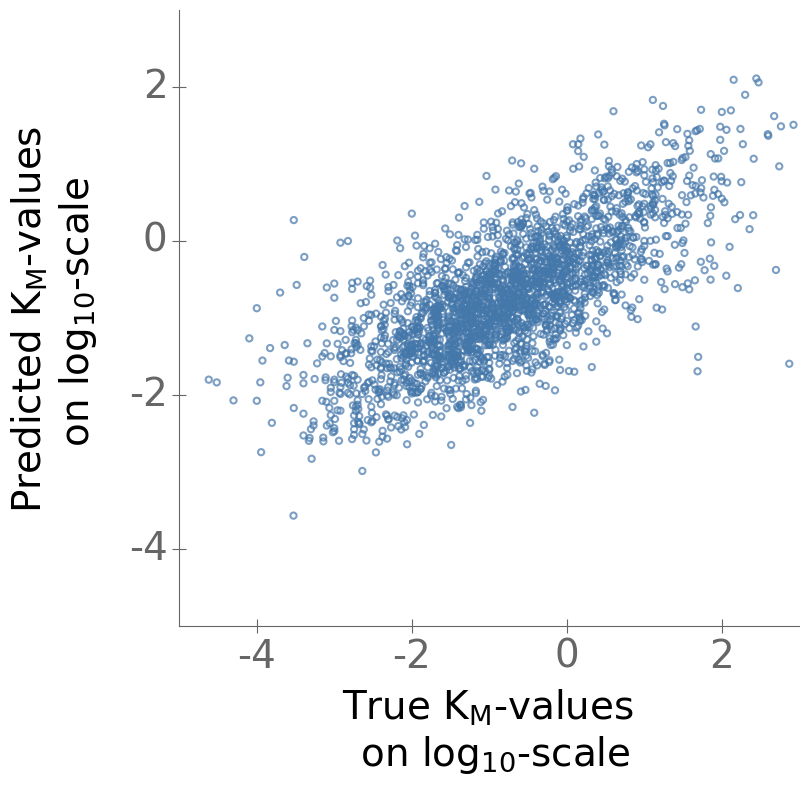

In [29]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

test_pred = pred_test_full_model


plt.ylim(ymax = 3, ymin = -5)
plt.xlim(xmax = 3, xmin = -5)

ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)

plt.ylabel("Predicted $K_M$-values \n on $\log_{10}$-scale")
plt.xlabel("True $K_M$-values \n on $\log_{10}$-scale")
plt.scatter(test_Y, test_pred, alpha = 0.7, s=20)
plt.show()

Prediction with the naive approach of taking the mean of the $ K_M$ values in the training set:

In [30]:
mean_pred = np.mean(train_Y)

mean_pred_test_MSE = np.mean(abs(mean_pred - np.reshape(test_Y, (-1)))**2)
mean_pred_test_R2 = np.round(r2_score(np.reshape(test_Y, (-1)), [mean_pred]*len(test_Y)),2)
print("Performance on the test set:")
print("R² value: %s" % mean_pred_test_R2)
print("Mean squared error: %s" % mean_pred_test_MSE)

Performance on the test set:
R² value: -0.0
Mean squared error: 1.382175088568349


#### Figure 4a and 4b:

In [31]:
#load results from substrate only model
GNN_CV_MSE = np.load(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_CV.npy"))
GNN_CV_R2 =  np.load(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_R2_CV.npy"))

GNN_test_MSE = np.load(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_test.npy"))
GNN_test_R2 = np.load(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_R2_test.npy"))

#load results on Sabio-RK dataset:
XGB_Sabio_MSE = np.load(join(datasets_dir, "training_results", "XGB_Sabio_MSE.npy"))
XGB_Sabio_R2 = np.load(join(datasets_dir, "training_results", "XGB_Sabio_R.npy"))

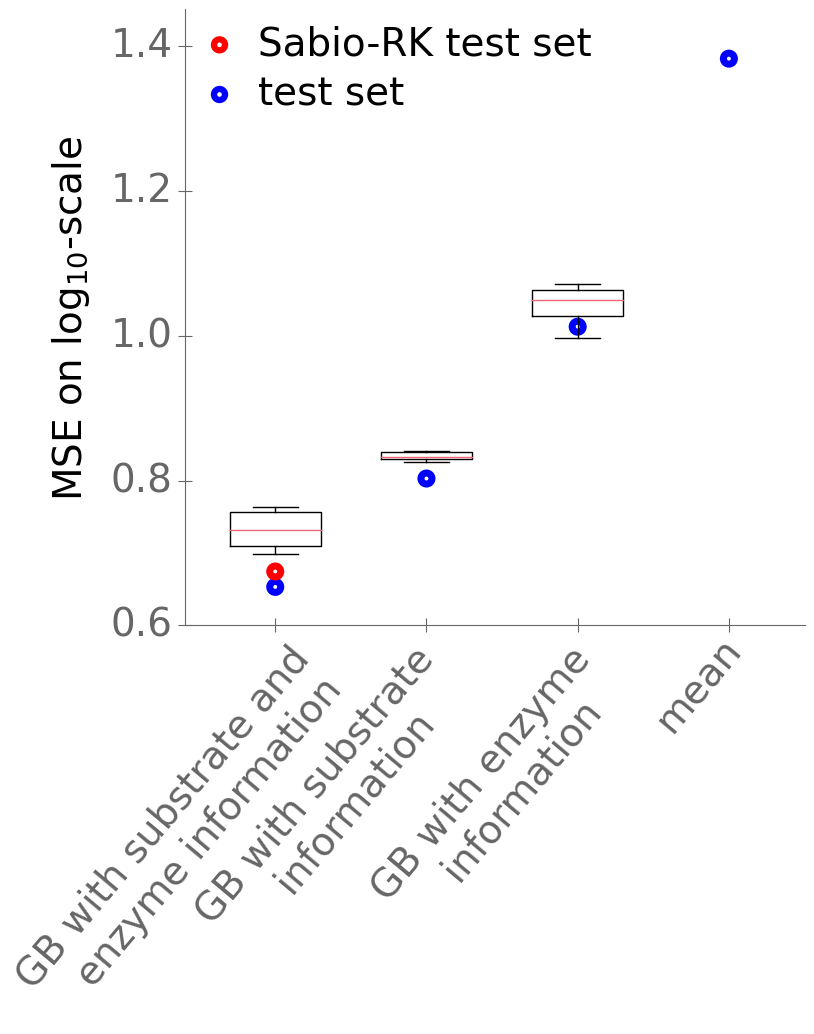

In [32]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["GB with substrate and \n  enzyme information",
                           "GB with substrate \n information", "GB with enzyme \n information", "mean"]

plt.scatter(1, GB_enzyme_sub_test_MSE, c='blue', marker='o', linewidths= 8)
plt.scatter(1, XGB_Sabio_MSE, c='red', marker='o', linewidths= 8, label ="Sabio-RK test set")
plt.scatter(2, GNN_test_MSE , c='blue', marker='o', linewidths= 8, label = "test set")
plt.scatter(3, GB_enzyme_test_MSE, c='blue', marker='o', linewidths= 8)
plt.scatter(4, mean_pred_test_MSE, c='blue', marker='o', linewidths= 8)

plt.boxplot([GB_enzyme_sub_CV_MSE,  GNN_CV_MSE, GB_enzyme_CV_MSE], positions=[1,2,3],  widths=0.6, whis =2)

plt.ylim(0.6, 1.45)
plt.xlim(0.6, 4.5)
ticks1 = [1,2,3,4]

ax.set_xticks(ticks1)
ax.set_xticklabels([])
ax.tick_params(axis='x', which="major", length=10)
ax.tick_params(axis='y', length=10)
ticks2 = [0.4, 1.4, 2.5, 3.8]

ax.set_xticks(ticks2, minor=True)
ax.set_xticklabels(labs, minor=True, y = 0.0)
ax.tick_params(axis='x', which="minor",length=0, rotation = 50)

plt.ylabel("MSE on $\log_{10}$-scale")
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.legend(loc = "upper left")
plt.show()

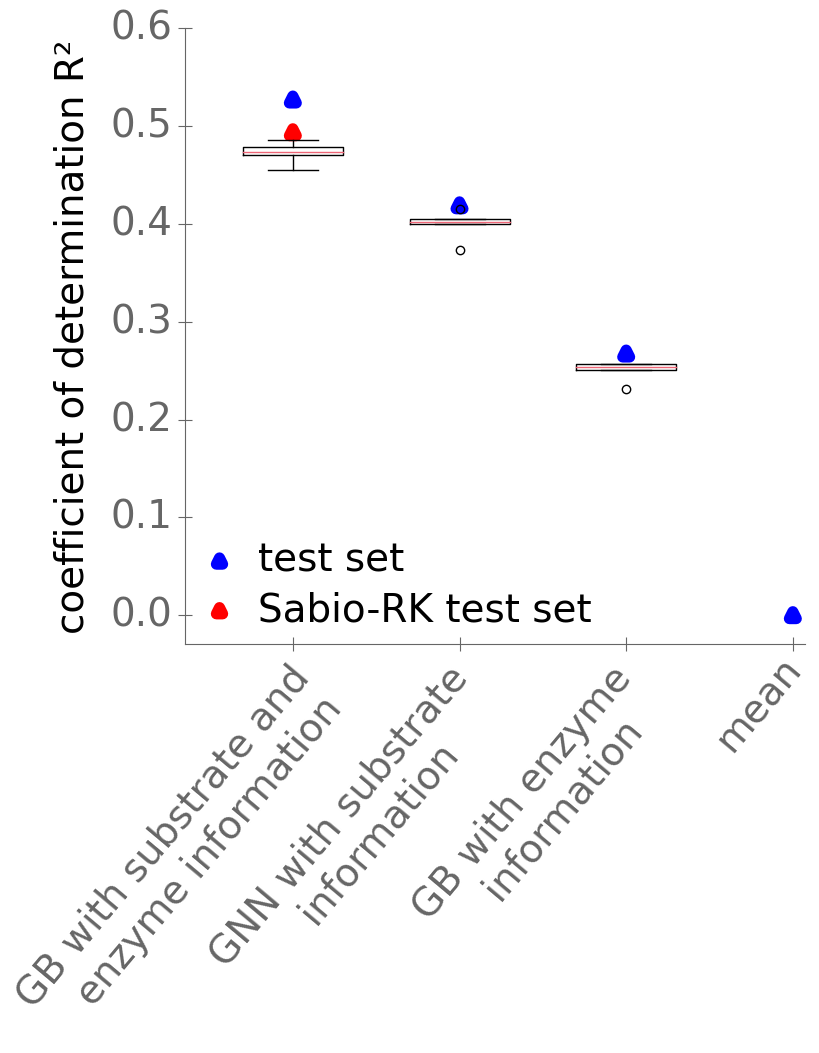

In [33]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["GB with substrate and \n  enzyme information",
                           "GNN with substrate \n information", "GB with enzyme \n information", "mean"]



plt.scatter(2, GNN_test_R2 , c='blue', marker='^', linewidths= 8, label = "test set")
plt.scatter(1, GB_enzyme_sub_test_R2, c='blue', marker='^', linewidths= 8)
plt.scatter(1, XGB_Sabio_R2, c='red', marker='^', linewidths= 8, label ="Sabio-RK test set")
plt.scatter(3, GB_enzyme_test_R2, c='blue', marker='^', linewidths= 8)
plt.scatter(4, mean_pred_test_R2, c='blue', marker='^', linewidths= 8)

plt.boxplot([GB_enzyme_sub_CV_R2,  GNN_CV_R2, GB_enzyme_CV_R2], positions=[1,2,3],  widths=0.6, whis =2)

plt.ylim(-0.03, 0.6)
ticks1 = [1,2,3,4]

ax.set_xticks(ticks1)
ax.set_xticklabels([])
ax.tick_params(axis='x', which="major", length=10)
ax.tick_params(axis='y', length=10)
ticks2 = [0.35, 1.4, 2.5, 3.8]

ax.set_xticks(ticks2, minor=True)
ax.set_xticklabels(labs, minor=True, y= 0.0)
ax.tick_params(axis='x', which="minor",length=0, rotation = 50)

plt.ylabel("coefficient of determination R²")
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.legend(loc = "lower left")
plt.show()